In [1]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END, StateGraph, START
from langgraph.types import Command
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langchain_ollama import ChatOllama
from langgraph.managed.is_last_step import RemainingSteps

In [2]:
ollama_model = ChatOllama(model="llama3.2")

In [3]:
ollama_model.invoke('hi')

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-04-20T16:26:39.234564Z', 'done': True, 'done_reason': 'stop', 'total_duration': 512063700, 'load_duration': 67809100, 'prompt_eval_count': 26, 'prompt_eval_duration': 57000000, 'eval_count': 8, 'eval_duration': 386000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-7b347e1b-86c8-497f-9c98-59c5f3cf11e3-0', usage_metadata={'input_tokens': 26, 'output_tokens': 8, 'total_tokens': 34})

In [4]:
members = ["calculator_agent", "formula_agent"]
options = members + ["FINISH"]
class Router(TypedDict):
     """Worker to route to next. If no workers needed, route to FINISH."""
     next: Literal["calculator_agent", "formula_agent", "FINISH"]
class State(MessagesState):
    next: str
    remaining_steps: RemainingSteps

In [5]:
system_prompt = f"""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the user's request, respond with the worker to act next. 
Each worker will perform a task and respond with results and status. 
When finished, respond with FINISH.
"""
def supervisor_node(state: State) -> Command[Literal["calculator_agent", "formula_agent", "__end__"]]:
    if state["remaining_steps"] <= 2:
        return Command(goto=END)
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = ollama_model.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END
    return Command(goto=goto, update={"next": goto})

In [6]:
@tool
def basic_calculator_tool(expression: Annotated[str, "A basic arithmetic expression like 2 + 3 * 4"]):
    """Evaluate a simple math expression and return the result."""
    try:
        result = eval(expression)
        return f"The result of '{expression}' is {result}"
    except Exception as e:
        return f"Error evaluating expression: {e}"


In [7]:
def calculator_agent_node(state: State) -> Command[Literal["supervisor"]]:
    calculator = create_react_agent(ollama_model, tools=[basic_calculator_tool])
    result = calculator.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="calculator_agent")
            ]
        },
        goto="supervisor"
    )


In [8]:
@tool
def math_formula_tool(topic: Annotated[str, "A math topic like area of circle or quadratic formula"]):
    """Return standard math formulas based on the topic."""
    formulas = {
        "area of circle": "Area = π × r²",
        "quadratic formula": "x = [-b ± √(b² - 4ac)] / (2a)",
        "pythagoras theorem": "c² = a² + b²",
        "circumference of circle": "C = 2πr"
    }
    topic_lower = topic.lower()
    return formulas.get(topic_lower, f"No formula found for '{topic}'")


In [9]:
def formula_agent_node(state: State) -> Command[Literal["supervisor"]]:
    formula_agent = create_react_agent(ollama_model, tools=[math_formula_tool])
    result = formula_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="formula_agent")
            ]
        },
        goto="supervisor"
    )


In [10]:
graph = StateGraph(State)
graph.add_node("supervisor", supervisor_node)
graph.add_node("calculator_agent", calculator_agent_node)
graph.add_node("formula_agent", formula_agent_node)
graph.add_edge(START, "supervisor")
app = graph.compile()

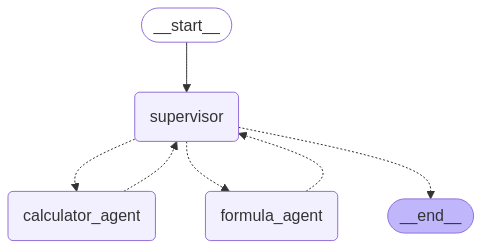

In [11]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
for s in app.stream({"messages": [("user", "What is 12 * (5 + 3)?")],"remaining_steps": 10}):
    print(s)
    print("----")

{'supervisor': {'next': 'calculator_agent'}}
----
{'calculator_agent': {'messages': [HumanMessage(content='The result of the expression `12 * (5 + 3)` is 96.', additional_kwargs={}, response_metadata={}, name='calculator_agent', id='f013f2c8-0a90-403c-a762-1fbf77b1ac2f')]}}
----
{'supervisor': {'next': 'formula_agent'}}
----
{'formula_agent': {'messages': [HumanMessage(content='To evaluate the expression `12 * (5 + 3)`, we need to follow the order of operations (PEMDAS):\n\n1. Evaluate the expression inside the parentheses: `5 + 3 = 8`\n2. Multiply 12 by the result: `12 * 8 = 96`\n\nSo, the correct answer is indeed 96!', additional_kwargs={}, response_metadata={}, name='formula_agent', id='7d368dee-b743-4f2c-b4e7-fb03e72f39f0')]}}
----
{'supervisor': {'next': 'calculator_agent'}}
----
{'calculator_agent': {'messages': [HumanMessage(content='6 x (2 + 4) = ?\n\nTo evaluate the expression `6 * (2 + 4)`, we need to follow the order of operations (PEMDAS):\n\n1. Evaluate the expression insi

In [13]:
for s in app.stream({"messages": [("user", "Give me the quadratic formula")],"remaining_steps": 10}):
    print(s)
    print("----")

{'supervisor': {'next': 'calculator_agent'}}
----
{'calculator_agent': {'messages': [HumanMessage(content='The quadratic formula is x = (-b ± √(b² - 4ac)) / 2a.', additional_kwargs={}, response_metadata={}, name='calculator_agent', id='92c48714-9f23-4d36-b9fa-3811f69e5c4c')]}}
----
{'supervisor': {'next': 'calculator_agent'}}
----
{'calculator_agent': {'messages': [HumanMessage(content='The quadratic formula is x = (-b ± √(b² - 4ac)) / 2a.', additional_kwargs={}, response_metadata={}, name='calculator_agent', id='0a29cbce-33ce-4b0d-bcbe-744a15736e2b')]}}
----
{'supervisor': {'next': 'calculator_agent'}}
----
{'calculator_agent': {'messages': [HumanMessage(content='The quadratic formula is x = (-b ± √(b² - 4ac)) / 2a.', additional_kwargs={}, response_metadata={}, name='calculator_agent', id='1398b0be-a5e5-4d13-b96a-b1f3304d0fdb')]}}
----
{'supervisor': {'next': 'calculator_agent'}}
----
{'calculator_agent': {'messages': [HumanMessage(content='The quadratic formula is x = (-b ± √(b² - 4a

In [14]:
for s in app.stream({"messages": [("user", "What is the area of a circle with radius 7")],"remaining_steps": 10}):
    print(s)
    print("----")

{'supervisor': {'next': 'formula_agent'}}
----
{'formula_agent': {'messages': [HumanMessage(content='The area of the circle is approximately 153.94 square units.', additional_kwargs={}, response_metadata={}, name='formula_agent', id='d44ebab7-c5c3-46fb-b51a-855d89c18c96')]}}
----
{'supervisor': {'next': 'formula_agent'}}
----
{'formula_agent': {'messages': [HumanMessage(content='Using the formula for the area of a circle, A = πr², where r is the radius of the circle.\n\nGiven that the radius of the circle is 7 units, we can calculate the area as follows:\n\nA = π(7)²\nA ≈ 3.14159 × 49\nA ≈ 153.94 square units\n\nSo, the area of a circle with radius 7 units is approximately 153.94 square units.', additional_kwargs={}, response_metadata={}, name='formula_agent', id='a1d7ac36-ce90-4d63-a2e8-5a8e9c695754')]}}
----
{'supervisor': {'next': 'calculator_agent'}}
----
{'calculator_agent': {'messages': [HumanMessage(content='The area of a circle with radius 7 units is approximately 153.94 square